# A2. Bias in Data

#### Samir D Patel
#### DATA 512 - HCDS¶
#### 11/2/2017

### Objective

In this notebook, I will be exploring bias through data obtained from WIkipedia articles on political figures from various countries.  

First, I will combine a dataset of Wikipedia articles with a second dataset of country populations.  A machine learning tool called ORES will be used on this combined dataset to estimate the article quality.

Next, an analysis will then look at coverage of politicans on Wikipedia and the how quality of articles about politicans varies between countries.

Then visualizations and/or output will be generated to display the following:

    1. The countries with the greatest and least coverage of politicians on Wikipedia compared to their population.
    
    2. The countries with the highest and lowest proportion of high quality articles about politicians.
    
Finally, I will summarize how this assignment affected my understanding of causes and consequences of bias on Wikiepdia.

#### Importing relevant Python packages.

In [1]:
import pickle
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1:  Getting Data sets

#### Wikipedia article data for "Politicians by country from the English-language Wikipedia"

    Released under the CC-BY-SA 4.0 license.

To obtain this data, I used the link https://figshare.com/articles/Untitled_Item/5513449, to download the file locally and unzip it.

#### Importing the Country Population data

In [2]:
page_data = pd.read_csv('./imported_data/page_data.csv')

population = pd.read_csv('./imported_data/Population Mid-2015.csv', header = 1, thousands=',')

In [3]:
#Create a list to store column of revision IDs from page_data.csv
rev_ids = []
rev_ids = page_data['rev_id']

#### Store all Rev_ID values into a string

In [4]:
rev_store = str(rev_ids[0])
i = 1
while i < len(rev_ids): 
    rev_store = rev_store + "|" + str(rev_ids[i])
    i+=1

### Step 2: Getting Article Quality Predictions using ORES

The step below loops through the "rev_store" variable which stores all rev_ids with a "|" delimitation.  It will take a chunk of 100 rev_ids from the "rev_store" variable and make a call to the ORES API on Wikipedia, which will return an JSON output into a "response" variable.  The final step in each loop will run an internal loop to extract the predictions from the JSON output and store each revision_id and prediction into a list.

In [5]:
predictions = []
beg = 0

endpoint = 'https://ores.wikimedia.org/v3/scores/{context}?models={models}&revids={revids}'
headers = {'User-Agent' : 'https://github.com/samirpdx', 'From' : 'sdpatel@uw.edu'}

for j in range(1 + int((len(rev_store)/1000))):

    end = beg + 999

    params = {'context' : 'enwiki',
              'models' : 'wp10',
              'revids' : rev_store[beg:end]
              }

    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()

    for key in response['enwiki']['scores']:
        try:
            val = response['enwiki']['scores'][key]['wp10']['score']['prediction']
            predictions.append([key, val])
        except: 
            print("RevID with Exception:", key)
            predictions.append([key, np.nan])
    beg = end +1    

RevID with Exception: 807367030
RevID with Exception: 807367166


    Attribution/Credit of example provided to help create code above:  Jonathan Morgan and Oliver Keyes (University of Washington, HCDE 512, Autumn 2017)

Note:  There are some revision_ids which are not associated with prediction scores.  These are listed above and were assigned "nan" to denote no articles.

#### Saving predictions with pickle package.

In [6]:
#The commented function below was used to store the data object containing predictions
# as processing takes a few minutes.

pickle.dump(predictions, open('predictions', 'wb'))

In [7]:
predictions = pickle.load(open('predictions', 'rb'))

### Step 3: Combining the data sets

Steps below will performing pre-processing steps to obtain final combined dataset of article predictions associated to population by country.

In [8]:
#Creating a dataframe for prediction values and converting data types as necessary.
df_predictions = pd.DataFrame(np.array(predictions))
df_predictions.columns = ['rev_id', "Prediction"]
df_predictions['rev_id'] = df_predictions['rev_id'].astype(np.int64)

#Merging Page Data and Predictions into new dataframe
page_data2 = pd.merge(page_data, df_predictions,left_on='rev_id', right_on='rev_id')
page_data2 = page_data2.drop_duplicates()

#Merging New Page Data (w/ Predictions) and Population
df_merged = pd.merge(page_data2, population,left_on='country', right_on='Location')
df_merged.sort_values('country').head(3)

#Dropping irrelevant columns and renaming others
df_merged = df_merged.drop('Location', axis=1)
df_merged = df_merged.drop('Location Type', axis=1)
df_merged = df_merged.drop('TimeFrame', axis=1)
df_merged = df_merged.drop('Data Type', axis=1)
df_merged = df_merged.drop('Footnotes', axis=1)
df_merged.columns = ['article_name', 'country',  'revision_id', 'article_quality', 'population']

Step below will output data as CSV to local directory.

In [9]:
df_merged.to_csv('./final_data/final_merged.csv', index=False)

### Step 4: Analysis

The steps below will calculate, as a percentage, the proportion of articles-per-population for each country.

In [10]:
group1 = df_merged.groupby(['country','population']).count().reset_index()
group1 = group1.drop('revision_id', axis=1)
group1 = group1.drop('article_quality', axis=1)
group1 = group1.rename(columns = {'article_name':'article_count'})
group1['articles_per_pop'] = 100*group1['article_count']/group1['population']

The steps below will calculate, as a percentage, the proportion of high-quality articles for each country.

    - "High quality" refers to the number of articles about politicians in a given country that ORES predicted would be in either the "FA" or "GA" classes

In [11]:
#Groupby to count total article quantities per quality category

group2 = df_merged.groupby(['country','article_quality']).count().reset_index()
group2 = group2.drop('population', axis=1)
group2 = group2.drop('revision_id', axis=1)
group2 = group2.rename(columns = {'article_name':'article_counts'})

In [12]:
#Groupby to count total article quantities per country

group2_total = group2.groupby(['country'])['article_counts'].sum().reset_index()
group2_total = group2_total.rename(columns = {'article_counts':'article_totals'})

In [13]:
#Creating a list to store all countries in dataset (for later aggregation reindexing)

country_list= pd.DataFrame(group2['country'].unique())

In [14]:
#Creating a subset of "High Quality" article categories, followed by aggregation by country
group2b = group2[(group2['article_quality']== 'FA') | (group2['article_quality']== 'GA')]
group2c = group2b.groupby('country')['article_counts'].sum()

#Reindexing to include countries with zero "High Quality" articles.
group2c = group2c.reindex(country_list[0], fill_value = 0)
group2c = pd.DataFrame(group2c).reset_index()
group2c = group2c.rename(columns = {0:'country'})

#Performing merge of High Quality article counts and Total article counts
group2c = pd.merge(group2c, group2_total,left_on='country', right_on='country')

#Creating column for percentage of high quality articles out of total

group2c['hqa_per_country']= 100*group2c['article_counts']/group2c['article_totals']

### Step 5: Visualization

### 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

In [15]:
graph1 = group1.sort_values(by = 'articles_per_pop', ascending = False).head(10)
graph1

,country,population,article_count,articles_per_pop
120,Nauru,10860,53,0.488029
173,Tuvalu,11800,55,0.466102
141,San Marino,33000,82,0.248485
113,Monaco,38088,40,0.105020
97,Liechtenstein,37570,29,0.077189
107,Marshall Islands,55000,37,0.067273
72,Iceland,330828,206,0.062268
168,Tonga,103300,63,0.060987
3,Andorra,78000,34,0.043590
54,Federated States of Micronesia,103000,38,0.036893


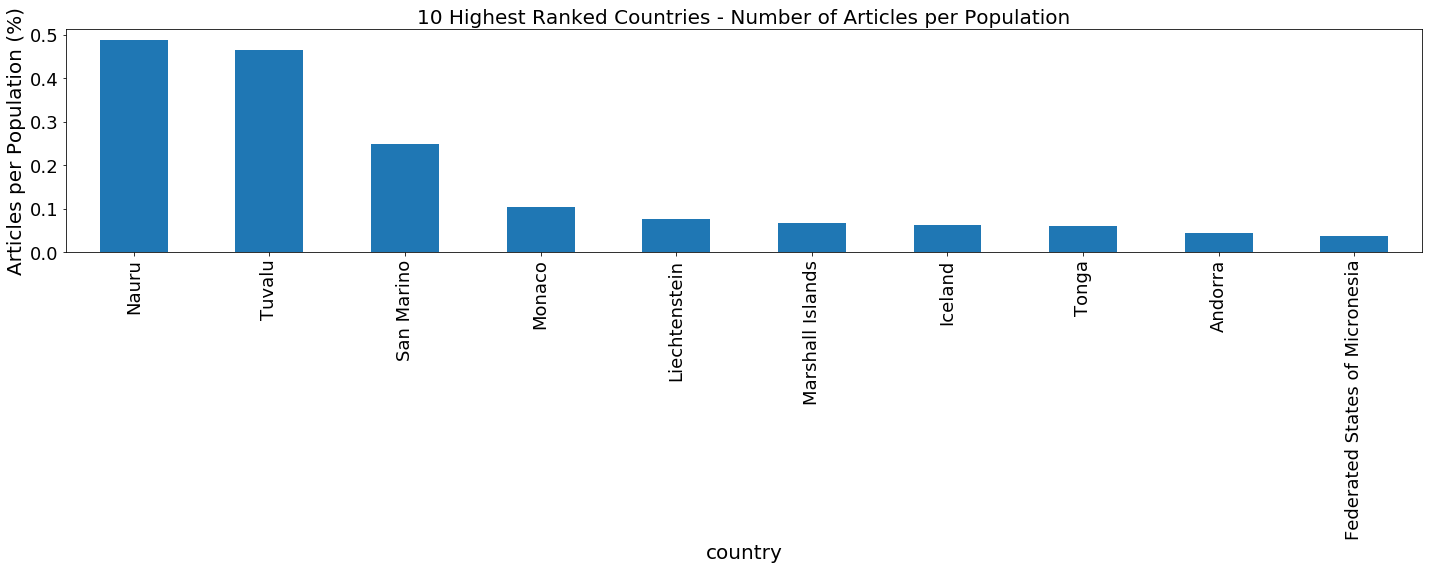

In [16]:
#Creating graph for 10 highest ranked countries for articles per population
p1 = graph1.plot(x = 'country', y = 'articles_per_pop', kind = 'bar', figsize =(20, 8),legend = False, fontsize = 18 )
plt.title("10 Highest Ranked Countries - Number of Articles per Population", fontsize = 20);
plt.xlabel("country", fontsize = 20)
plt.ylabel("Articles per Population (%)", fontsize = 20)
plt.tight_layout()
plt.savefig('./images/articles_per_pop_top10.png')


### 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

In [17]:
graph2 = group1.sort_values(by = 'articles_per_pop', ascending = True).head(10)
graph2

,country,population,article_count,articles_per_pop
73,India,1314097616,990,0.000075
34,China,1371920000,1138,0.000083
74,Indonesia,255741973,215,0.000084
180,Uzbekistan,31290791,29,0.000093
53,Ethiopia,98148000,105,0.000107
86,"Korea, North",24983000,39,0.000156
185,Zambia,15473900,26,0.000168
166,Thailand,65121250,112,0.000172
38,"Congo, Dem. Rep. of",73340200,142,0.000194
13,Bangladesh,160411000,324,0.000202


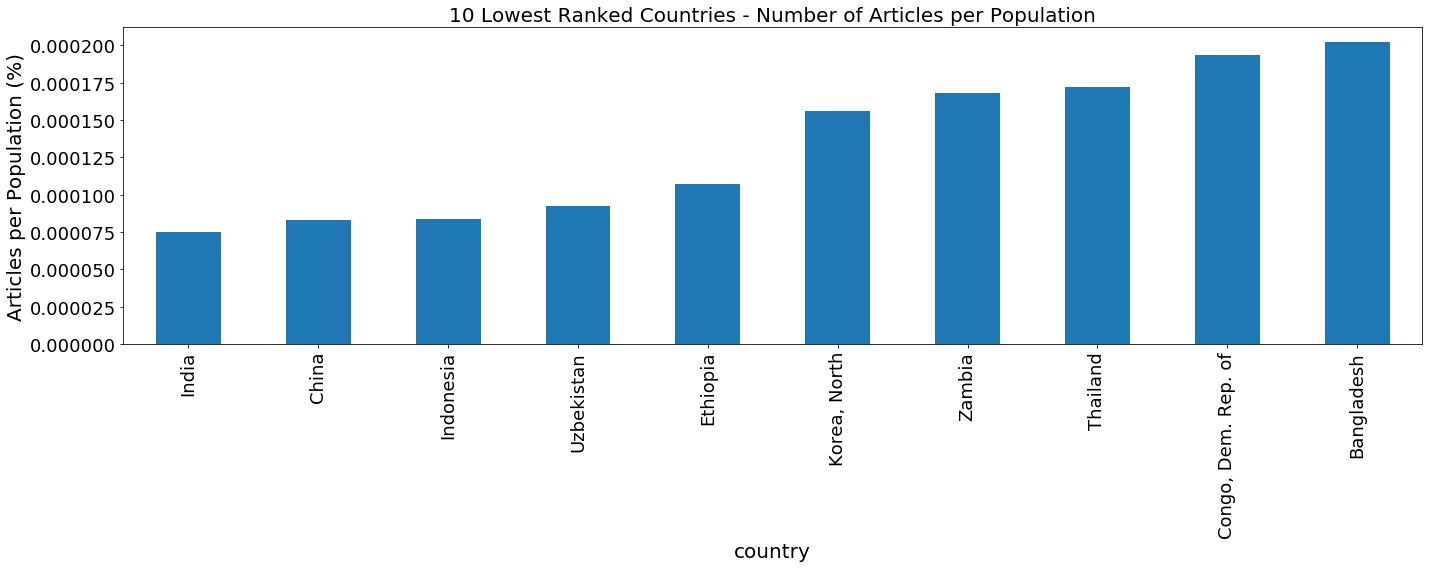

In [18]:
#Creating graph for 10 lowest ranked countries for articles per population
p2 = graph2.plot(x = 'country', y = 'articles_per_pop', kind = 'bar', figsize =(20, 8),legend = False, fontsize = 18 )
plt.title("10 Lowest Ranked Countries - Number of Articles per Population", fontsize = 20);
plt.xlabel("country", fontsize = 20)
plt.ylabel("Articles per Population (%)", fontsize = 20)
plt.tight_layout()
plt.savefig('./images/articles_per_pop_bot10.png')

### 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [19]:
graph3 = group2c.sort_values(by = 'hqa_per_country', ascending = False).head(10)
graph3

,country,article_counts,article_totals,hqa_per_country
86,"Korea, North",9,39,23.076923
138,Romania,45,348,12.931034
143,Saudi Arabia,15,119,12.605042
31,Central African Republic,8,68,11.764706
137,Qatar,5,51,9.803922
68,Guinea-Bissau,2,21,9.523810
183,Vietnam,18,191,9.424084
19,Bhutan,3,33,9.090909
77,Ireland,31,381,8.136483
178,United States,86,1098,7.832423


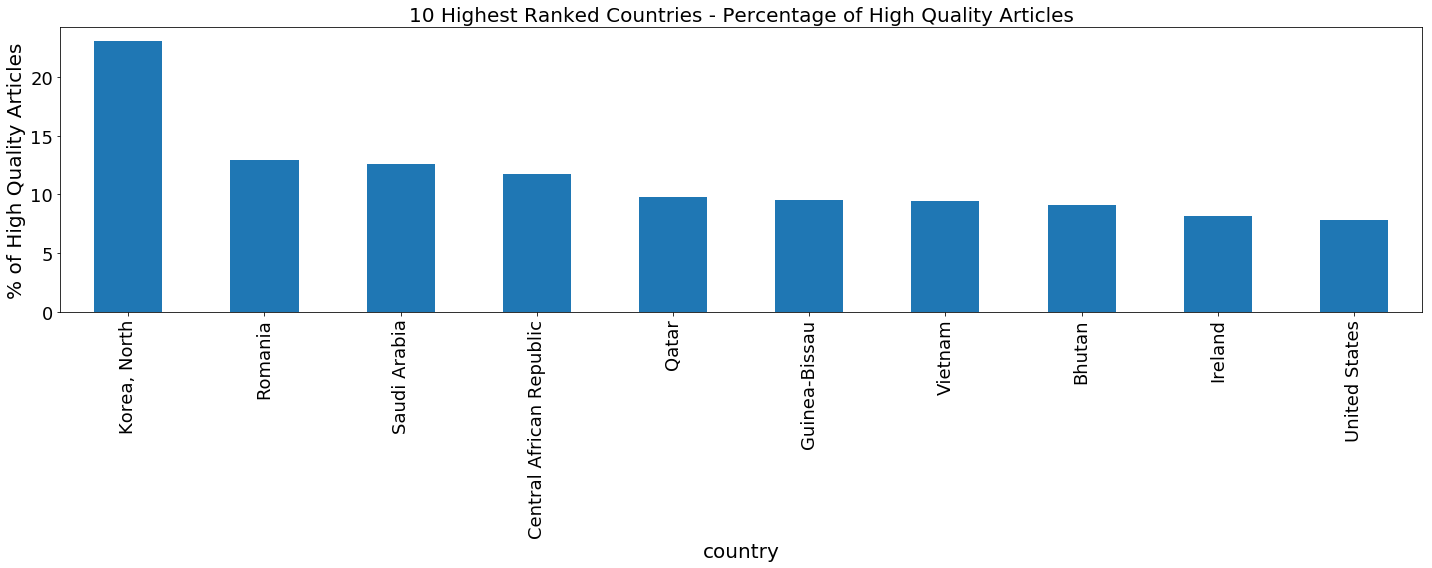

In [20]:
#Creating graph for 10 highest ranked countries for percentage of high quality articles
p3 = graph3.plot(x = 'country', y = 'hqa_per_country', kind = 'bar', figsize =(20, 8),legend = False, fontsize = 18 )
plt.title("10 Highest Ranked Countries - Percentage of High Quality Articles", fontsize = 20);
plt.xlabel("country", fontsize = 20)
plt.ylabel("% of High Quality Articles", fontsize = 20)
plt.tight_layout()
plt.savefig('./images/hqa_country_top10.png')

### 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [21]:
graph4 = group2c.sort_values(by = 'hqa_per_country', ascending = True).head(39)
graph4

,country,article_counts,article_totals,hqa_per_country
142,Sao Tome and Principe,0,22,0.0
172,Turkmenistan,0,33,0.0
107,Marshall Islands,0,37,0.0
69,Guyana,0,20,0.0
36,Comoros,0,51,0.0
170,Tunisia,0,140,0.0
45,Djibouti,0,39,0.0
46,Dominica,0,12,0.0
100,Macedonia,0,65,0.0
168,Tonga,0,63,0.0


Note: No plot was created for the 10 lowest-ranked countries (to be clear 39 countries are tied for lowest), since all values were 0.

### Step 6: Reflections

In doing this exercise, my reflection process started with directly assessing the plotted results for answering the questions of lowest/highest rankings for politican article proportion and high quality article proportion respectively.  Ultimately, scrutinizing this data  led to a natural line of questions of considering model bias.  Some questions of mine included: How is the model trained? How are the weights of the model determined and set?  And how has the model has been updated over time (did it ever degrade over time)?

The plotted results of the proportion of articles about politicans showed the highest ranked countries were ones with some of the highest populations in the world (China, India).  And the lowest countries were in similar fashion, some of the lowest populations (Nauru, Tuvalu).  So while proportion could be considered a normalizing metric to fairly consider article contribution across all countries, it did seem that population was an overwhelmingly dominant factor.  One other factor that is harder to assess and not necessarily transparent is the technological availability in all countries and their social segments to make editing contributions to such Wikipedia articles.

When reviewing the results of "high quality" article proportions, the "highest" results immediately raised questions for me.   This is in part to having an American citizen's perspective of global politics.  Countries like North Korea, Saudi Arabia and Qatar,and their leaders tend to get negative coverage in some U.S. media, yet their rankings indicate they have some of the highest proportion of "high-quality" articles.  Although I have some existing biases of my own, this did raise questions about the ORES model and how its prediction ratings (described as being based on factual completeness, content, and language quality) are being applied. One theory I had was that perhaps bias in these ratings could be partially due to political leanings of reviewers and could have affected a training data set and future predictions.  And with ever-changing political climates in countries, did the model get adequate updating to account for fluctuations in political opinions (unless we are to assume ratings they are solely grounded in facts).

Overall, this exercise was helpful in examining bias in a machine learning application by taking a step back from the results and looking at the model from a holistic perspective.  While it is easy to accept any algorithm blindly for its results, it is becoming more important than ever, in a world growing more reliant on such tools, to have a healthy skepticism and to perform due diligence on algorithmic models' inputs, implementation and outputs.
